In [60]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from skimage import io, transform
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import scipy
import random
import pickle
import scipy.io as sio

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.ion()

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from torchvision import transforms
import torchvision
from skimage import color
from torch.optim import lr_scheduler
from torchvision.utils import make_grid
import nibabel

In [61]:
import pickle
def pickling(file,path):
    pickle.dump(file,open(path,'wb'))
def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return

In [62]:
available_segments = [  0,   2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  72,  77,
        80,  85, 251, 252, 253, 254, 255]

In [65]:
len(available_segments)

46

In [63]:
# available_segments_req = [0,2,3,41,42]
# available_segments_req_index = [0,1,2,21,22]

In [66]:
class BrainImages(Dataset):
    def __init__(self, image_dir, label_dir, train_data = False, flipping = True, rotation = True, translation = True):
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.flipping = flipping
        self.rotation = rotation
        self.translation = translation
        self.train_data = train_data

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self,idx):
        image_path = "/gpfs/data/"+self.image_dir[idx]
        aseg_path = "/gpfs/data/"+self.label_dir[idx]
        
        img_orig = nibabel.freesurfer.mghformat.MGHImage.from_filename(image_path)
        image = img_orig.get_data().astype(np.float64)
        aseg_img = nibabel.freesurfer.mghformat.MGHImage.from_filename(aseg_path)
        aseg_img = aseg_img.get_data().astype(np.float64)

        flip = random.random() > 0.5
        angle = random.uniform(-5,5)
        dx = np.round(random.uniform(-10,10))
        dy = np.round(random.uniform(-10,10))
        
        im = Image.fromarray(image[0])
        target = Image.fromarray(aseg_img[0])
        if self.train_data:
            if self.flipping and flip:
                im = im.transpose(0)
                target = target.transpose(0)
            if self.rotation:
                im = im.rotate(angle)
                target = target.rotate(angle)
            if self.translation:
                im = im.transform((256,256),0, (1,0,dx,0,1,dy))
                target = target.transform((256,256),0,(1,0,dx,0,1,dy))
                
        im = torch.from_numpy(np.array(im, np.float64, copy=False).reshape((1,256,256)))/255
        target = np.array(target, np.float64, copy=False)
        target_label = np.zeros((6,256,256))
        for i,a in enumerate(available_segments):
            temp = (target==a).astype(int)
            if i in [0,1,2,21,22]:
                target_label[[0,1,2,21,22].index(i),:,:] = temp
            else:
                target_label[5,:,:] = target_label[5,:,:] + temp
        target_label[5,:,:] = (target_label[5,:,:]>=1).astype(int) 
#        print(target_label.shape)
        target_label = torch.from_numpy(target_label)
        sample = {'x':im,'y':target_label} 
        return sample

In [67]:
# # torch.from_numpy()
# train_file_names = unpickling("/scratch/ark576/train_file_names")
# train_label_names = unpickling("/scratch/ark576/train_label_names")
# rand1 = np.arange(len(train_file_names))
# np.random.shuffle(rand1)
# rand1 = rand1[:1000]

# val_file_names = unpickling("/scratch/ark576/val_file_names")
# val_label_names = unpickling("/scratch/ark576/val_label_names")
# rand2 = np.arange(len(val_file_names))
# np.random.shuffle(rand2)
# rand2 = rand2[:250]

# test_file_names = unpickling("/scratch/ark576/test_file_names")
# test_label_names = unpickling("/scratch/ark576/test_label_names")
# rand3 = np.arange(len(test_file_names))
# np.random.shuffle(rand3)
# rand3 = rand3[:3]




In [68]:
file_names = pd.read_csv("all_complete_path.csv")

In [69]:
file_names.head()

,left_to_right_raw,left_to_right_segmented,top_to_bottom_raw,top_to_bottom_segmented,back_to_front_raw,back_to_front_segmented
0,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
1,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
2,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
3,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
4,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...


In [70]:
train_subjects = unpickling("train_subject_index")
val_subjects = unpickling("val_subject_index")
test_subjects = unpickling("test_subject_index")

In [71]:
full_train_raw = list(file_names.iloc[train_subjects,2])
full_train_seg = list(file_names.iloc[train_subjects,3])

full_val_raw = list(file_names.iloc[val_subjects,2])
full_val_seg = list(file_names.iloc[val_subjects,3])

full_test_raw = list(file_names.iloc[test_subjects,2])
full_test_seg = list(file_names.iloc[test_subjects,3])

In [85]:
rand1 = np.arange(len(full_train_raw))
np.random.shuffle(rand1)
rand1 = rand1[:4980]

rand2 = np.arange(len(val_subjects))
np.random.shuffle(rand2)
rand2 = rand2[:500]

rand3 = np.arange(len(test_subjects))
np.random.shuffle(rand3)
rand3 = rand3[:3]

In [86]:
transformed_dataset = {'train': BrainImages(np.array(full_train_raw)[rand1],np.array(full_train_seg)[rand1], train_data= True, flipping=False),
                       'validate': BrainImages(np.array(full_val_raw)[rand2],np.array(full_val_seg)[rand2]),
                       'test': BrainImages(np.array(full_test_raw)[rand3],np.array(full_test_seg)[rand3])
                                               }

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=30,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

In [87]:
inputs = next(iter(dataloader['train']))

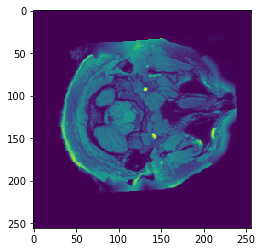

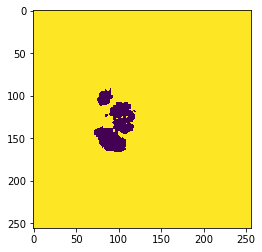

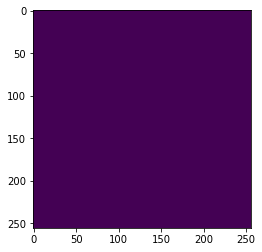

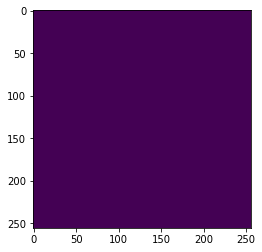

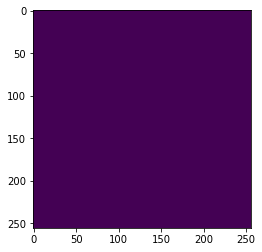

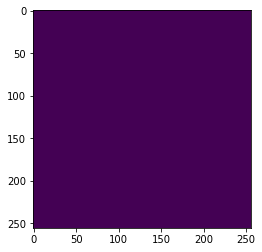

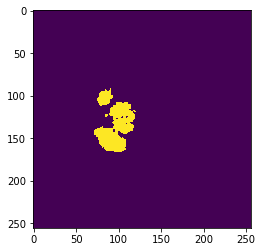

In [88]:
m = 0
plt.imshow(inputs['x'][m,0,:,:].numpy())
plt.show()
for i in range(6):
    plt.imshow(inputs['y'][m,i,:,:].numpy())
    plt.show()

In [89]:
5980/30

199.33333333333334

In [90]:
df_seg = pd.DataFrame(columns=np.arange(6))
ll = 0
batch = 30
for data in dataloader["train"]:
    print(ll)
    y = data['y'].numpy()
    #print(y.shape)
    for i in range(batch):
        for j in range(6):
            s = np.sum(y[i,j,:,:])
            df_seg.loc[ll*batch+i,j] = s
    ll = ll + 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165


In [91]:
df_seg.shape

(4980, 6)

In [92]:
class Downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(y, 2,stride = 2)
        
        return x, y

In [93]:
class Upsample_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Upsample_block, self).__init__()
        self.transconv = nn.ConvTranspose2d(in_channels, out_channels, 4, padding = 1, stride = 2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self,x, y):
        x = self.transconv(x)
        x = torch.cat((x,y),dim = 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        return x

In [94]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.down1 = Downsample_block(1,64)
        self.down2 = Downsample_block(64,128)
        self.down3 = Downsample_block(128,256)
        self.down4 = Downsample_block(256,512)
        self.conv1 = nn.Conv2d(512,1024, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.conv2 = nn.Conv2d(1024,1024,3, padding = 1)
        self.bn2 = nn.BatchNorm2d(1024)
        self.up4 = Upsample_block(1024,512)
        self.up3 = Upsample_block(512,256)
        self.up2 = Upsample_block(256,128)
        self.up1 = Upsample_block(128,64)
        self.outconv = nn.Conv2d(64,6, 1)
        
    def forward(self,x):
        x, y1 = self.down1(x)
        x, y2 = self.down2(x)
        x, y3 = self.down3(x)
        x, y4 = self.down4(x)
        x = F.dropout2d(F.relu(self.bn1(self.conv1(x))))
        x = F.dropout2d(F.relu(self.bn2(self.conv2(x))))
        x = self.up4(x, y4)
        x = self.up3(x, y3)
        x = self.up2(x, y2)
        x = self.up1(x, y1)
        x = self.outconv(x)
        
        return x

In [45]:
# voxel_count = pd.read_csv('/gpfs/data/cbi/hcp/hcp_seg/brain_segmentation/segment_counts.csv')

In [46]:
# wts_num1 = np.mean(np.array(voxel_count.iloc[:,available_segments]),axis = 0)

In [47]:
# wts_num = list(wts_num1[[0,1,2,21,22]])
# wts_num.append(np.sum(wts_num1) - np.sum(wts_num))

In [95]:
wts_num = np.mean(np.array(df_seg),axis=0)

In [96]:
wts_torch = Variable(torch.from_numpy(np.array(wts_num))).cuda()

In [97]:
wts_torch

tensor([ 60458.1566,    924.7002,   1094.5620,    952.6088,   1112.8831,
           993.0892], dtype=torch.float64, device='cuda:0')

In [107]:
def dice_loss_2(true1,scores1,mean, epsilon = 1e-4,p = 1.25):
    N, C, sh1, sh2 = true1.size()
    
    true = []
    scores = []
    for c in range(N):
        if not torch.sum(true1[c,1:,:,:])==0:
            true.append(true1[c,:,:,:])
            scores.append(scores1[c,:,:,:])
    try:
        true = torch.stack(true)
        scores = torch.stack(scores)
    except:
        return -1
    N, C, sh1, sh2 = true.size()
    
    
    preds = F.softmax(scores)
    true = true.view(N, C, -1)
    preds = preds.view(N, C, -1)
    wts = torch.sum(true, dim = 2) + epsilon
    mean = 1/torch.pow(mean,p)
    wts[:,:] = mean[None].repeat(N,1)
    wts = wts/(torch.sum(wts,dim = 1)[:,None])
    prod = torch.sum(true*preds,dim = 2)
    sum_tnp = torch.sum(true + preds, dim = 2)
    num = torch.sum(wts * prod, dim = 1)
    denom = torch.sum(wts * sum_tnp, dim = 1) + epsilon
    loss = 1 - 2*(num/denom)
    return torch.mean(loss)

In [108]:
def dice_score(true1,scores1, epsilon = 1e-7):
    N ,C, sh1, sh2 = true1.size()
    true = []
    scores = []
    for c in range(N):
        if not torch.sum(true1[c,1:,:,:])==0:
            true.append(true1[c,:,:,:])
            scores.append(scores1[c,:,:,:])
    try:
        true = torch.stack(true)
        scores = torch.stack(scores)
    except:
        return 0
    
    N, C, sh1, sh2 = true.size()
    
    true = true.view(N,C,-1)
    preds = F.softmax(scores)
    pred_class = (torch.max(preds, dim = 1)[1]).view(N,-1)
    class_score = [0]*6
    for i in range(6):
        class_score[i] = (pred_class == i).data.type(torch.cuda.FloatTensor)
    true = true.data.type(torch.cuda.FloatTensor)
    def numerator(truth,pred, idx):
        return(torch.sum(truth[:,idx,:] * pred,dim = 1)) + epsilon/2
    def denominator(truth,pred,idx):
        return(torch.sum(truth[:,idx,:]+pred,dim = 1)) + epsilon
    dice_class_score = [0]*6
    for i in range(6):
        dice_class_score[i] = torch.mean(2*(numerator(true,class_score[i],i))/(denominator(true,class_score[i],i)))
    return dice_class_score
    

In [109]:
import time
def train_model(model, optimizer,dataloader, data_sizes, batch_size, num_epochs = 100, verbose = False):
    since = time.time()
    best_loss = np.inf
    loss_hist = {'train':[],'validate':[]}
    dice_scores_of_all_class = [{'train':[],'validate':[]} for i in range(6)]    
    for i in range(num_epochs):
        for phase in ['train', 'validate']:
            running_loss = 0
            run_class_scores = [0]*6
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)
    
            for data in dataloader[phase]:
                optimizer.zero_grad()
                x = data['x']
                y = data['y']
                x = Variable(x).type(torch.FloatTensor).cuda()
                y = Variable(y).type(torch.FloatTensor).cuda()
                
                output = model(x)
                loss = dice_loss_2(y, output,wts_torch)
                if loss==-1:
                    continue
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.data[0] * batch_size
                dice_score_batch = dice_score(y,output)

                for j in range(6):
                    run_class_scores[j] = run_class_scores[j] + dice_score_batch[j] * batch_size
            epoch_loss = running_loss/data_sizes[phase]
            loss_hist[phase].append(epoch_loss.item()) 
            for j in range(6):
                score = run_class_scores[j]/data_sizes[phase]
                dice_scores_of_all_class[j][phase].append(score.to(torch.device("cpu")).numpy())
            if verbose or i%1 == 0:
                print('Epoch: {}, Phase: {}, epoch loss: {:.4f}'.format(i,phase,epoch_loss))
                print('-'*10)
            
        if phase == 'validate' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = model.state_dict() 
        #print(i)
    print('-'*50)    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val dice loss: {:4f}'.format(best_loss))
    
    model.load_state_dict(best_model_wts)
    
    return model, loss_hist, dice_scores_of_all_class

In [110]:
model = Unet().cuda()
model = nn.DataParallel(model)
criterion = dice_loss_2

optimizer = optim.Adam(model.parameters(),lr = 5e-4)
#scheduler = lr_scheduler.StepLR(optimizer,step_size = 15)

In [111]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,data_sizes,30,
                                                                num_epochs = 11, verbose = True)

Epoch: 0, Phase: train, epoch loss: 0.6119
----------
Epoch: 0, Phase: validate, epoch loss: 0.7855
----------
Epoch: 1, Phase: train, epoch loss: 0.2215
----------
Epoch: 1, Phase: validate, epoch loss: 0.2482
----------
Epoch: 2, Phase: train, epoch loss: 0.1287
----------
Epoch: 2, Phase: validate, epoch loss: 0.2684
----------
Epoch: 3, Phase: train, epoch loss: 0.1052
----------
Epoch: 3, Phase: validate, epoch loss: 0.1665
----------
Epoch: 4, Phase: train, epoch loss: 0.0944
----------
Epoch: 4, Phase: validate, epoch loss: 0.3567
----------
Epoch: 5, Phase: train, epoch loss: 0.0894
----------
Epoch: 5, Phase: validate, epoch loss: 0.1584
----------
Epoch: 6, Phase: train, epoch loss: 0.0797
----------
Epoch: 6, Phase: validate, epoch loss: 0.1418
----------
Epoch: 7, Phase: train, epoch loss: 0.0808
----------
Epoch: 7, Phase: validate, epoch loss: 0.1999
----------
Epoch: 8, Phase: train, epoch loss: 0.0767
----------
Epoch: 8, Phase: validate, epoch loss: 0.2592
----------
E

In [116]:
torch.save(model.state_dict(), "semi_model3")

In [122]:
loss_hist

{'train': [0.6119093894958496,
  0.22154222428798676,
  0.12866072356700897,
  0.10517123341560364,
  0.09444467723369598,
  0.08942191302776337,
  0.07970020174980164,
  0.08075260370969772,
  0.0767190083861351,
  0.07076548784971237,
  0.07005850970745087],
 'validate': [0.7854604721069336,
  0.24823220074176788,
  0.2683663070201874,
  0.1665182262659073,
  0.3567148745059967,
  0.15843817591667175,
  0.1417958289384842,
  0.1999405324459076,
  0.2591758966445923,
  0.17415635287761688,
  0.529136061668396]}

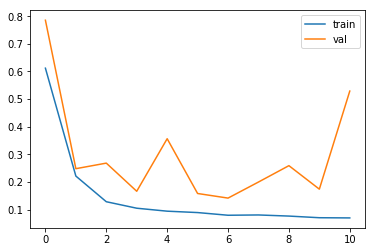

In [123]:
plt.plot(loss_hist["train"],label="train")
plt.plot(loss_hist["validate"],label="val")
plt.legend()
plt.show()

In [112]:
def visualize1(image):
    p = F.softmax(image)
    p_maxim = torch.max(p, dim=0)[1]
    img = []
    for seg in range(6):
        masked = (p_maxim==seg).data.type(torch.cuda.FloatTensor)
        img.append(masked)
    return torch.stack(img).resize(6,1,256,256).cpu()

In [113]:
%matplotlib inline
def show(img):    
    npimg = img.numpy()
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

In [114]:
def visualize_few():
    data = next(iter(dataloader["validate"]))
    model.train(False)
    x = data['x']
    y = data['y']
    x = Variable(x).type(torch.FloatTensor).cuda()
    y = Variable(y).type(torch.FloatTensor).cuda()
                
    output = model(x)
    for i in range(11):
        print('-'*100)
        print('Ground Truth')
        abc = data['y'][i,:,:,:]
        bcd = abc.resize(6,1,256,256)
        show(make_grid(bcd,padding=10,pad_value=1)) 
        print('-'*100)
        print('Prediction')
        show(make_grid(visualize1(output[i,:,:,:]),padding=10,pad_value=1))

----------------------------------------------------------------------------------------------------
Ground Truth


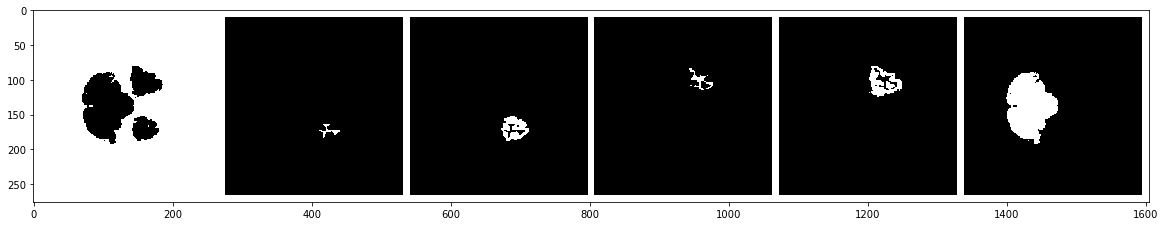

----------------------------------------------------------------------------------------------------
Prediction


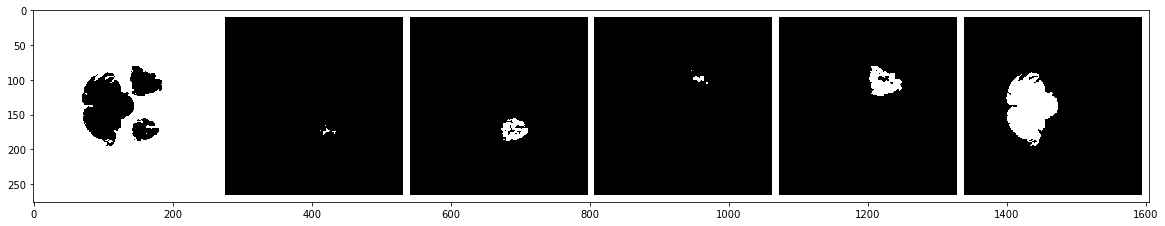

----------------------------------------------------------------------------------------------------
Ground Truth


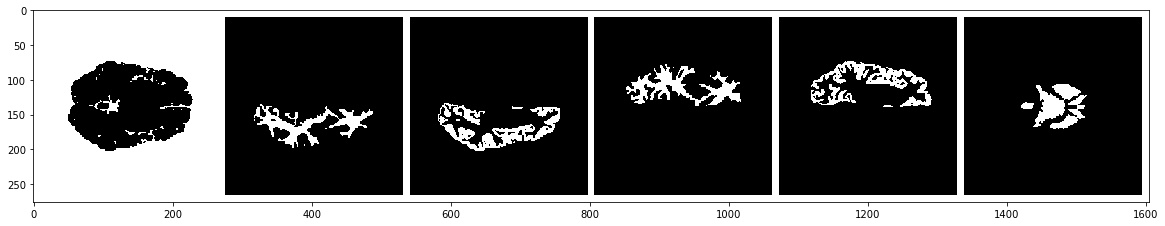

----------------------------------------------------------------------------------------------------
Prediction


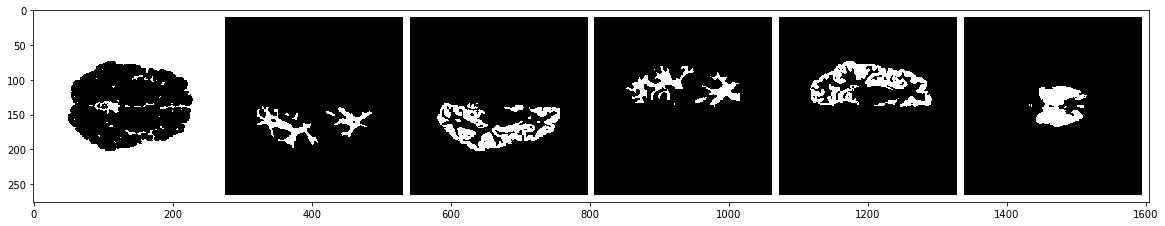

----------------------------------------------------------------------------------------------------
Ground Truth


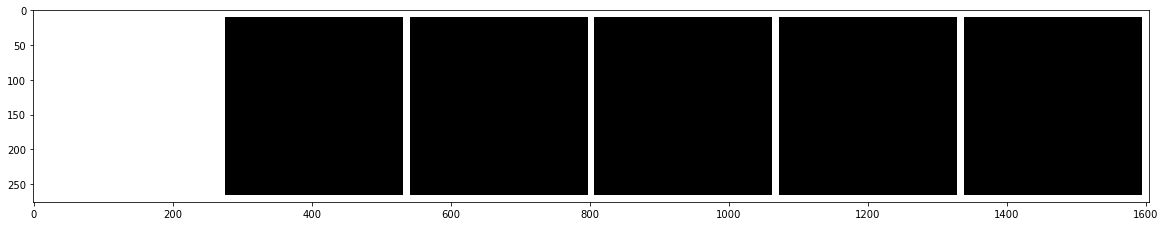

----------------------------------------------------------------------------------------------------
Prediction


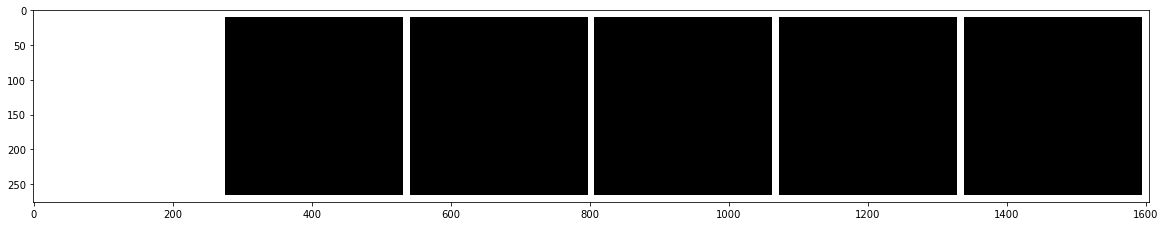

----------------------------------------------------------------------------------------------------
Ground Truth


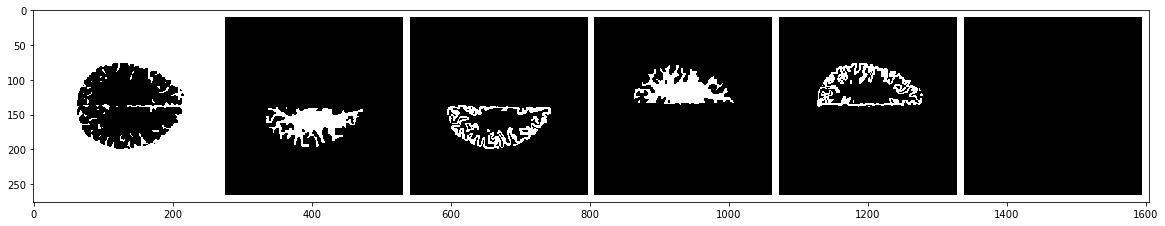

----------------------------------------------------------------------------------------------------
Prediction


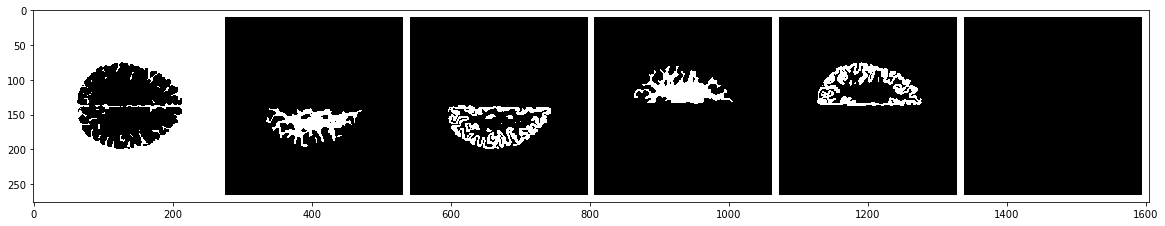

----------------------------------------------------------------------------------------------------
Ground Truth


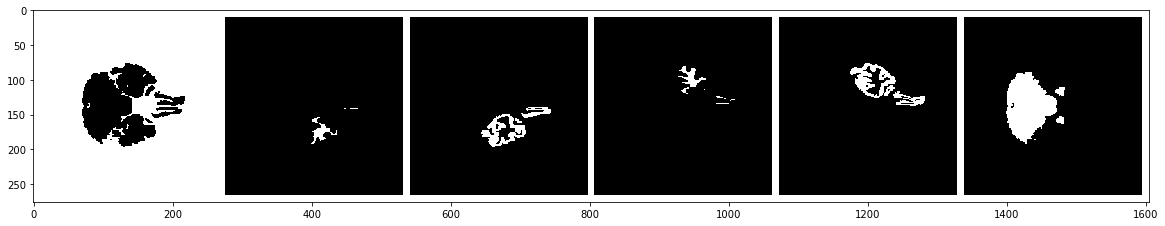

----------------------------------------------------------------------------------------------------
Prediction


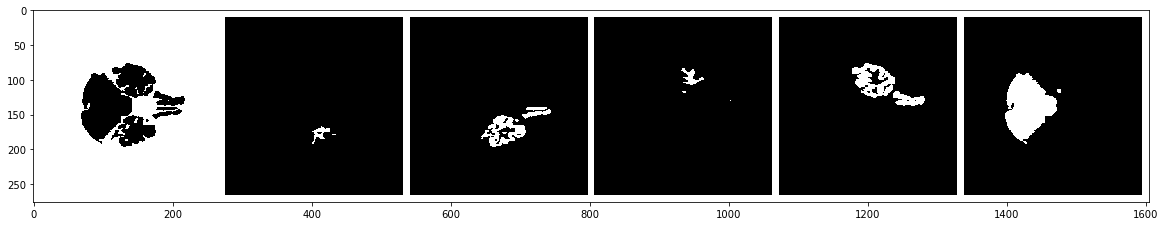

----------------------------------------------------------------------------------------------------
Ground Truth


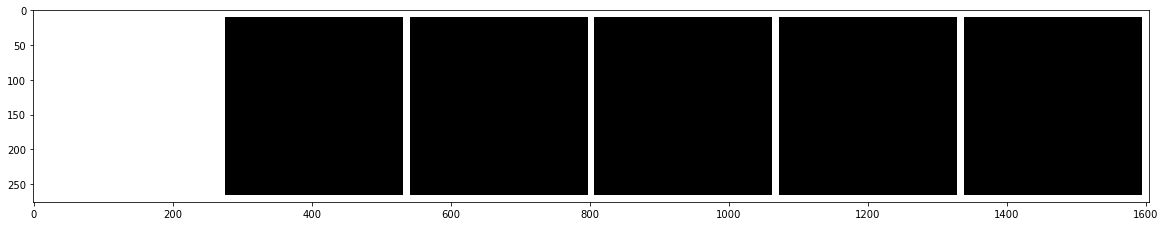

----------------------------------------------------------------------------------------------------
Prediction


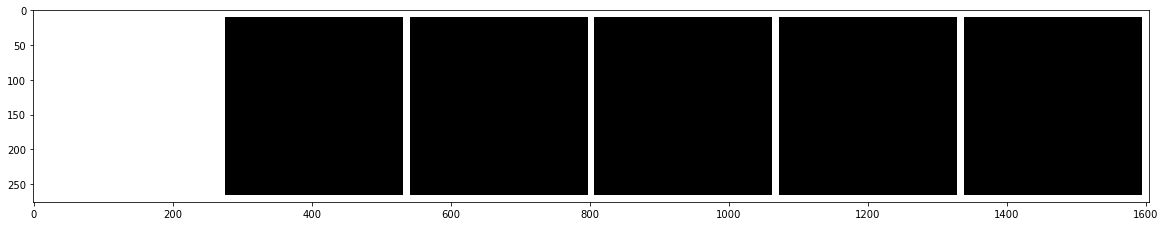

----------------------------------------------------------------------------------------------------
Ground Truth


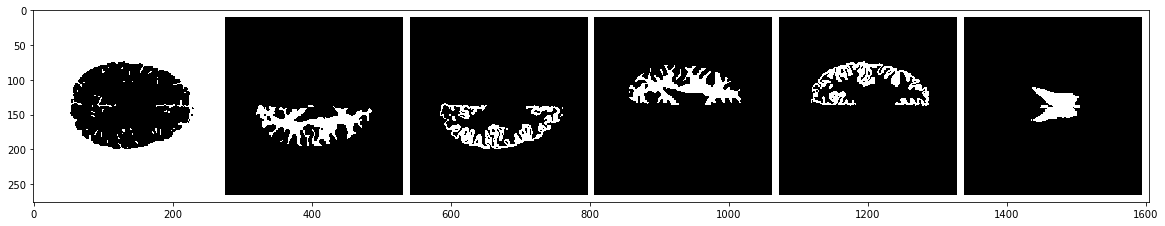

----------------------------------------------------------------------------------------------------
Prediction


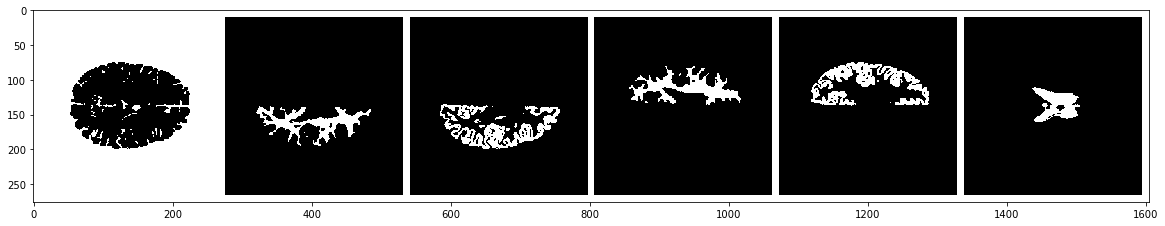

----------------------------------------------------------------------------------------------------
Ground Truth


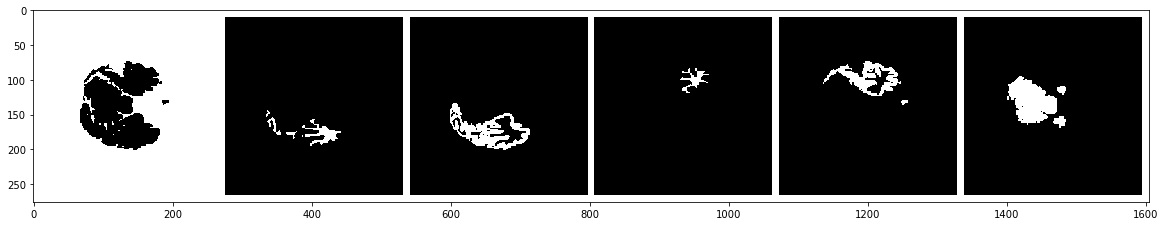

----------------------------------------------------------------------------------------------------
Prediction


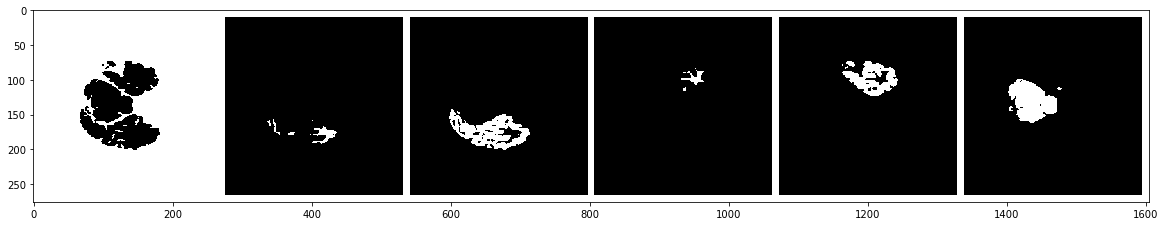

----------------------------------------------------------------------------------------------------
Ground Truth


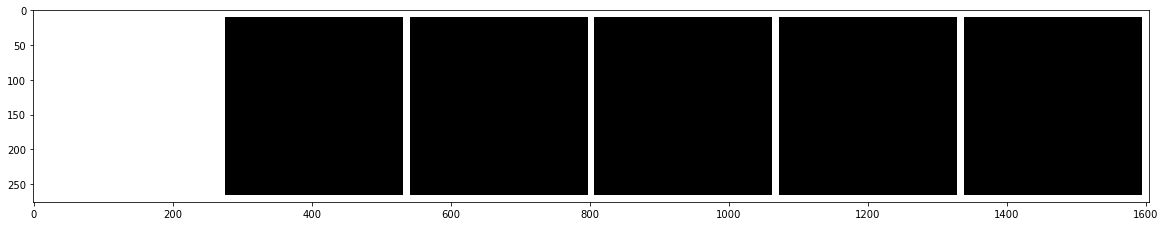

----------------------------------------------------------------------------------------------------
Prediction


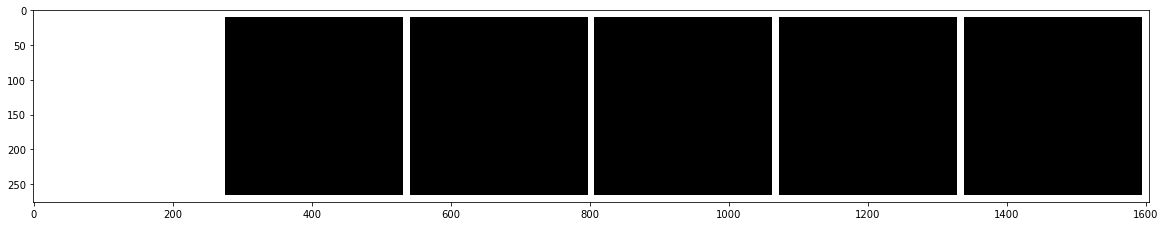

----------------------------------------------------------------------------------------------------
Ground Truth


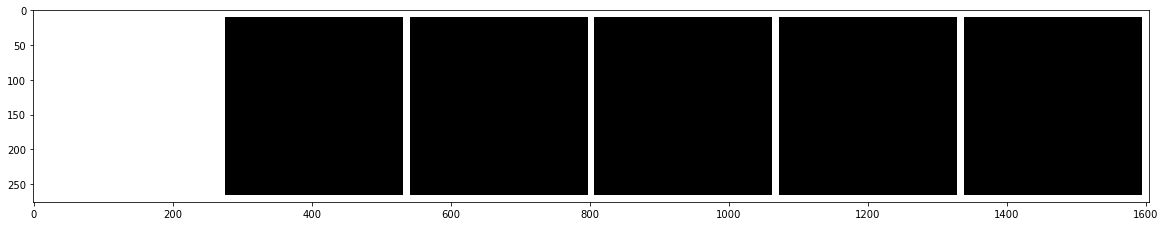

----------------------------------------------------------------------------------------------------
Prediction


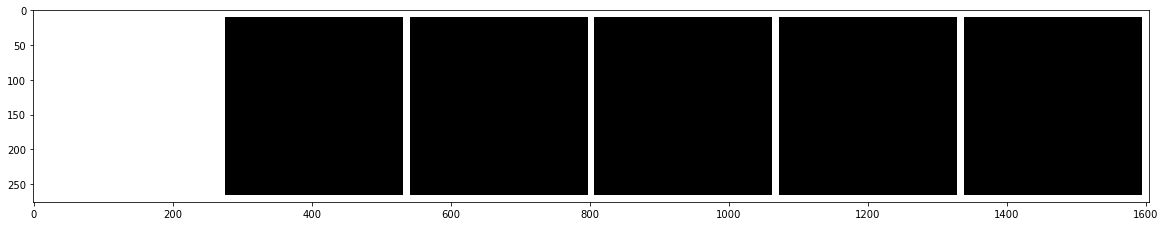

----------------------------------------------------------------------------------------------------
Ground Truth


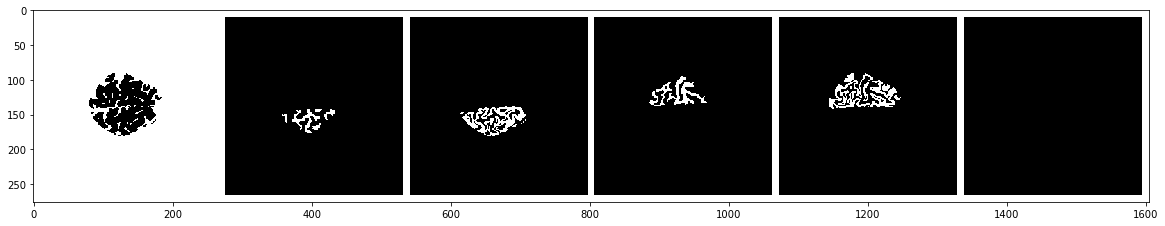

----------------------------------------------------------------------------------------------------
Prediction


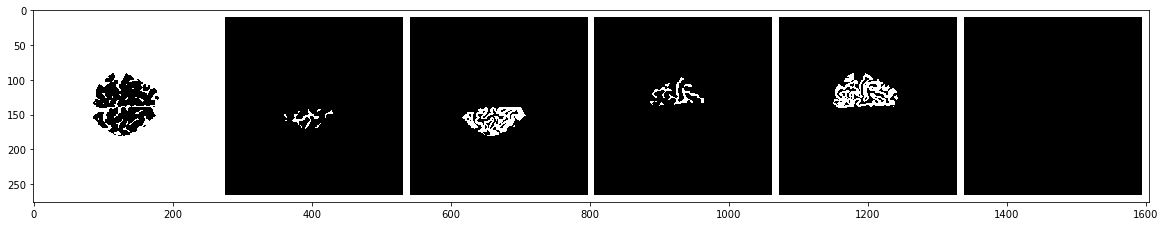

In [115]:
visualize_few()

In [117]:
names = []
for i in range(11):
    name = "epoch"+str(i)
    names.append(name)

In [118]:
train_dice_scores = pd.DataFrame(columns=names)
val_dice_scores = pd.DataFrame(columns=names)

In [119]:
for i in range(6):
    class_i_train = dice_hist[i]['train']
    class_i_val = dice_hist[i]['validate']
    train_dice_scores.loc[i] = class_i_train
    val_dice_scores.loc[i] = class_i_val

In [120]:
train_dice_scores

,epoch0,epoch1,epoch2,epoch3,epoch4,epoch5,epoch6,epoch7,epoch8,epoch9,epoch10
0,0.8699671,0.98833203,0.9926481,0.99376416,0.99427867,0.99456596,0.9956118,0.99569803,0.9958357,0.9961384,0.9961781
1,0.5573836,0.8062528,0.871258,0.89060366,0.8977493,0.89701796,0.9049185,0.90464646,0.9077218,0.91438866,0.91603595
2,0.48940098,0.7556914,0.8301257,0.8514989,0.8633864,0.85610676,0.87734604,0.8710381,0.8766697,0.8895274,0.8862655
3,0.57644445,0.8118523,0.8743183,0.89046866,0.8930919,0.8999426,0.90981907,0.9069937,0.9111947,0.91911125,0.9195001
4,0.46355334,0.7569635,0.8186587,0.8457923,0.8674128,0.8649995,0.877292,0.87640095,0.8790496,0.8897752,0.89187545
5,0.38251323,0.6403275,0.7428411,0.75869566,0.7703058,0.7880525,0.8274068,0.8207942,0.84917897,0.8570035,0.8597666


In [121]:
val_dice_scores

,epoch0,epoch1,epoch2,epoch3,epoch4,epoch5,epoch6,epoch7,epoch8,epoch9,epoch10
0,0.554786,1.0113795,1.0081421,1.0122659,0.99790215,1.0121449,1.0147493,1.0130744,1.0088322,1.0101182,1.0150393
1,0.35755643,0.63238364,0.6320676,0.8066707,0.6669382,0.78556734,0.8321068,0.6704709,0.6700158,0.73529065,0.7931835
2,0.5162262,0.70201164,0.69160295,0.83006483,0.6537641,0.80620074,0.8205641,0.7495216,0.73950714,0.7749947,0.8456539
3,0.3162604,0.703496,0.72452337,0.77283907,0.7322514,0.8340963,0.83312196,0.8487547,0.62054217,0.85347456,0.8390937
4,0.5262241,0.7587635,0.74888676,0.8055691,0.6349607,0.74741083,0.81357884,0.8052789,0.70437765,0.76532686,0.82823724
5,0.079213016,0.6750447,0.7072697,0.72457045,0.30050713,0.8145128,0.7388692,0.80777025,0.69419056,0.84272134,0.8493568
